In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/talus-sagittal/image_0178.jpg
/kaggle/input/talus-sagittal/image_0073.jpg
/kaggle/input/talus-sagittal/image_0123.jpg
/kaggle/input/talus-sagittal/image_0219.jpg
/kaggle/input/talus-sagittal/image_0188.jpg
/kaggle/input/talus-sagittal/image_0089.jpg
/kaggle/input/talus-sagittal/image_0217.jpg
/kaggle/input/talus-sagittal/image_0040.jpg
/kaggle/input/talus-sagittal/image_0030.jpg
/kaggle/input/talus-sagittal/image_0091.jpg
/kaggle/input/talus-sagittal/image_0183.jpg
/kaggle/input/talus-sagittal/image_0157.jpg
/kaggle/input/talus-sagittal/image_0062.jpg
/kaggle/input/talus-sagittal/image_0190.jpg
/kaggle/input/talus-sagittal/image_0203.jpg
/kaggle/input/talus-sagittal/image_0096.jpg
/kaggle/input/talus-sagittal/image_0155.jpg
/kaggle/input/talus-sagittal/image_0175.jpg
/kaggle/input/talus-sagittal/image_0020.jpg
/kaggle/input/talus-sagittal/image_0044.jpg
/kaggle/input/talus-sagittal/image_0198.jpg
/kaggle/input/talus-sagittal/image_0023.jpg
/kaggle/input/talus-sagittal/ima

# Environment setup

In [2]:
import torch
import torchvision
print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("CUDA is available:", torch.cuda.is_available())
import sys
!{sys.executable} -m pip install opencv-python matplotlib
!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/sam2.git'

# !mkdir -p videos
# !wget -P videos https://dl.fbaipublicfiles.com/segment_anything_2/assets/bedroom.zip
# !unzip -d videos videos/bedroom.zip

!mkdir -p ../checkpoints/
!wget -P ../checkpoints/ https://dl.fbaipublicfiles.com/segment_anything_2/092824/sam2.1_hiera_large.pt

PyTorch version: 2.4.0
Torchvision version: 0.19.0
CUDA is available: True
  Cloning https://github.com/facebookresearch/sam2.git to /tmp/pip-req-build-135uibma
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/sam2.git /tmp/pip-req-build-135uibma
  Resolved https://github.com/facebookresearch/sam2.git to commit 29267c8e3965bb7744a436ab7db555718d20391a
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 1.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 4.5 MB/s eta 0:00:00
  Created wheel for SAM-2: filename=SAM_2-1.0-cp310-cp310-linux_x86_

In [3]:
import os
# if using Apple MPS, fall back to CPU for unsupported ops
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image

In [4]:
# select the device for computation
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
elif device.type == "mps":
    print(
        "\nSupport for MPS devices is preliminary. SAM 2 is trained with CUDA and might "
        "give numerically different outputs and sometimes degraded performance on MPS. "
        "See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion."
    )

using device: cuda


In [5]:
!mkdir -p videos
!wget -P videos https://dl.fbaipublicfiles.com/segment_anything_2/assets/bedroom.zip
!unzip -d videos videos/bedroom.zip

--2024-10-01 21:58:38--  https://dl.fbaipublicfiles.com/segment_anything_2/assets/bedroom.zip
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 18.173.166.31, 18.173.166.51, 18.173.166.48, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|18.173.166.31|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12688166 (12M) [application/zip]
Saving to: 'videos/bedroom.zip'

bedroom.zip         100%[===================>]  12.10M  57.1MB/s    in 0.2s    

2024-10-01 21:58:39 (57.1 MB/s) - 'videos/bedroom.zip' saved [12688166/12688166]

Archive:  videos/bedroom.zip
   creating: videos/bedroom/
  inflating: videos/bedroom/00005.jpg  
  inflating: videos/bedroom/00121.jpg  
  inflating: videos/bedroom/00079.jpg  
  inflating: videos/bedroom/00126.jpg  
  inflating: videos/bedroom/00002.jpg  
  inflating: videos/bedroom/00128.jpg  
  inflating: videos/bedroom/00070.jpg  
  inflating: videos/bedroom/00185.jpg  
  inflating: videos/bedroom/00154.jpg  

In [5]:
!find /opt/conda/lib/python3.10/ -name "*sam2*" -type d

/opt/conda/lib/python3.10/site-packages/sam2
/opt/conda/lib/python3.10/site-packages/sam2/configs/sam2
/opt/conda/lib/python3.10/site-packages/sam2/configs/sam2.1
/opt/conda/lib/python3.10/site-packages/sam2/configs/sam2.1_training


In [6]:
!ls /opt/conda/lib/python3.10/site-packages/sam2/

_C.so			     configs		 sam2_hiera_s.yaml
__init__.py		     csrc		 sam2_hiera_t.yaml
__pycache__		     modeling		 sam2_image_predictor.py
automatic_mask_generator.py  sam2_hiera_b+.yaml  sam2_video_predictor.py
build_sam.py		     sam2_hiera_l.yaml	 utils


In [8]:
!git clone https://github.com/facebookresearch/sam2.git

Cloning into 'sam2'...
remote: Enumerating objects: 940, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 940 (delta 0), reused 0 (delta 0), pack-reused 936 (from 1)
Receiving objects: 100% (940/940), 128.92 MiB | 35.84 MiB/s, done.
Resolving deltas: 100% (317/317), done.


In [ ]:
!cp -r /content/sam2/sam2/configs /opt/conda/lib/python3.10/site-packages/sam2/

In [ ]:
!ls /usr/local/lib/python3.10/dist-packages/sam2/

In [7]:
!pwd

/kaggle/working


# Loadind the model

In [8]:
from sam2.build_sam import build_sam2_video_predictor

sam2_checkpoint = "../checkpoints/sam2.1_hiera_large.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_l.yaml"

predictor = build_sam2_video_predictor(model_cfg, sam2_checkpoint, device=device)

/opt/conda/lib/python3.10/site-packages/sam2/modeling/sam/transformer.py:23: UserWarning: Flash Attention is disabled as it requires a GPU with Ampere (8.0) CUDA capability.
  OLD_GPU, USE_FLASH_ATTN, MATH_KERNEL_ON = get_sdpa_settings()


In [10]:
def show_mask(mask, ax, obj_id=None, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        cmap = plt.get_cmap("tab10")
        cmap_idx = 0 if obj_id is None else obj_id
        color = np.array([*cmap(cmap_idx)[:3], 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_points(coords, labels, ax, marker_size=200):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)


def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))

# Importing dicom series

We assume that the video is stored as a list of JPEG frames with filenames like <frame_index>.jpg.
Otherwise run the below

In [11]:
rm -r talus-sagittal

rm: cannot remove 'talus-sagittal': No such file or directory


In [12]:
import os
import shutil

# Directory containing the CT images
input_dir = "/kaggle/input/talus-sagittal"
output_dir = "/kaggle/working/talus-sagittal"  # Create a new directory for the copied files
# Remove the output directory if it exists to avoid keeping older files
if os.path.exists(output_dir):
    shutil.rmtree(output_dir)  # Remove the directory and its contents

# Create a new output directory
os.makedirs(output_dir, exist_ok=True)

# List and sort all the file names in the input directory
frames = [name for name in os.listdir(input_dir) if name.lower().endswith(('.jpg', '.jpeg'))]
frames.sort(key=lambda x: int(x.split('_')[1].split('.')[0]))  # Sort by numeric index extracted from filenames

# print(frames)
for name in frames:
    # Extract the numeric part and convert to integer
    index = name.split('_')[1]
#     print(index)
    
#     # Create the new filename
#     new_name = f"{index}.jpg"
    
    # Define full paths for old and new filenames
    old_path = os.path.join(input_dir, name)
    new_path = os.path.join(output_dir, index)
    
    # Copy and rename the file
    shutil.copyfile(old_path, new_path)

# List the renamed files to verify
renamed_files = os.listdir(output_dir)

# # Sort the renamed files to ensure correct order
# renamed_files.sort(key=lambda x: int(x.split('.')[0]))  # Sort by numeric index
print(renamed_files)

['0087.jpg', '0037.jpg', '0134.jpg', '0080.jpg', '0143.jpg', '0137.jpg', '0098.jpg', '0108.jpg', '0142.jpg', '0129.jpg', '0149.jpg', '0011.jpg', '0029.jpg', '0155.jpg', '0008.jpg', '0179.jpg', '0188.jpg', '0146.jpg', '0051.jpg', '0066.jpg', '0120.jpg', '0048.jpg', '0119.jpg', '0116.jpg', '0147.jpg', '0175.jpg', '0075.jpg', '0231.jpg', '0163.jpg', '0150.jpg', '0034.jpg', '0016.jpg', '0090.jpg', '0067.jpg', '0228.jpg', '0064.jpg', '0201.jpg', '0015.jpg', '0139.jpg', '0199.jpg', '0070.jpg', '0171.jpg', '0114.jpg', '0058.jpg', '0165.jpg', '0173.jpg', '0166.jpg', '0153.jpg', '0210.jpg', '0220.jpg', '0035.jpg', '0012.jpg', '0223.jpg', '0110.jpg', '0091.jpg', '0046.jpg', '0081.jpg', '0172.jpg', '0127.jpg', '0148.jpg', '0057.jpg', '0232.jpg', '0204.jpg', '0113.jpg', '0229.jpg', '0053.jpg', '0084.jpg', '0203.jpg', '0151.jpg', '0213.jpg', '0154.jpg', '0092.jpg', '0023.jpg', '0198.jpg', '0093.jpg', '0031.jpg', '0133.jpg', '0040.jpg', '0076.jpg', '0218.jpg', '0086.jpg', '0028.jpg', '0152.jpg', '02

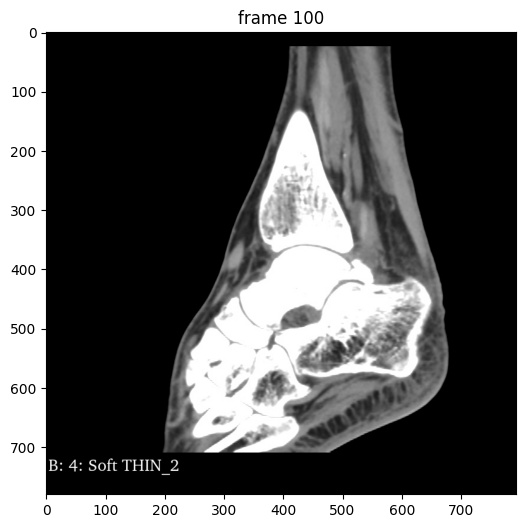

In [13]:
# import re
video_dir = "/kaggle/working/talus-sagittal"

# scan all the JPEG frame names in this directory
frame_names = [
    p for p in os.listdir(video_dir)
    if os.path.splitext(p)[-1] in [".jpg", ".jpeg", ".JPG", ".JPEG"]
]
frame_names.sort(key=lambda p: int(os.path.splitext(p)[0]))

# # Sort frame names by extracting the numeric part from the filenames
# frame_names.sort(key=lambda p: int(re.search(r'\d+', os.path.splitext(p)[0]).group()))
# print(frame_names)

# take a look the first video frame
frame_idx = 100
plt.figure(figsize=(9, 6))
plt.title(f"frame {frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[frame_idx])))

# Initialize the inference state

During initialization, it loads all the JPEG frames in video_path and stores their pixels in inference_state (as shown in the progress bar below).

In [25]:
inference_state = predictor.init_state(video_path=video_dir)

frame loading (JPEG): 100%|██████████| 234/234 [00:08<00:00, 27.74it/s]


Note: if you have run any previous tracking using this inference_state, please reset it first via reset_state.
(The cell below is just for illustration; it's not needed to call reset_state here as this inference_state is just freshly initialized above.)

In [24]:
predictor.reset_state(inference_state)

### Step 1: Add a first click on a frame

Retrieving the click coordinates through interactive click

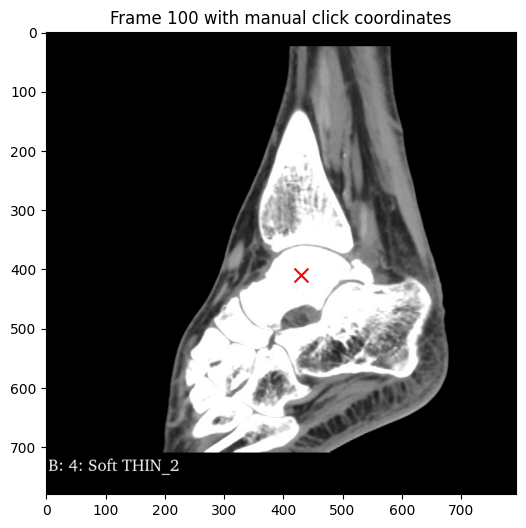

Manually selected coordinates: x=430, y=410


In [26]:
# import matplotlib.pyplot as plt
from PIL import Image
import os

# Manually input coordinates after visually inspecting the image
manual_coords = [(430, 410)]  # Example coordinates

# Display the CT image
frame_idx = 100  # Replace with the index of the CT image you want to work with
image_path = os.path.join(video_dir, frame_names[frame_idx])
img = Image.open(image_path)

plt.figure(figsize=(9, 6))
plt.imshow(img)
plt.title(f"Frame {frame_idx} with manual click coordinates")

# Plot the manual coordinates
x, y = manual_coords[0]
plt.scatter([x], [y], color='red', marker='x', s=100)
plt.show()

# Use the coordinates in your segmentation task
print(f"Manually selected coordinates: x={x}, y={y}")

Making a positive click at the extracted coordinates.

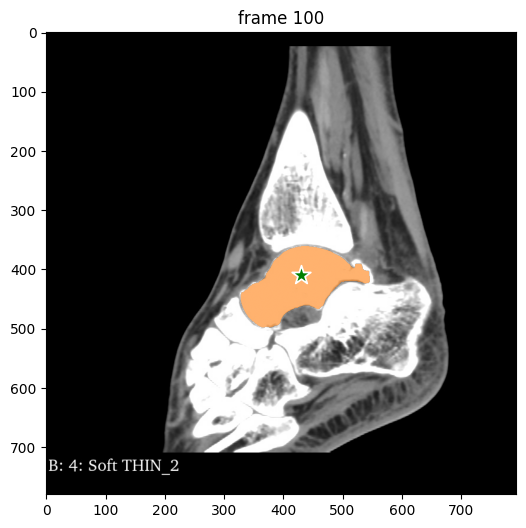

In [32]:
ann_frame_idx = 100  # the frame index we interact with
ann_obj_id = 1  # give a unique id to each object we interact with (it can be any integers)

# Let's add a positive click at (x, y) = (210, 350) to get started
points = np.array([[x, y]], dtype=np.float32)
# for labels, `1` means positive click and `0` means negative click
labels = np.array([1], np.int32)
_, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
    inference_state=inference_state,
    frame_idx=ann_frame_idx,
    obj_id=ann_obj_id,
    points=points,
    labels=labels,
)

# show the results on the current (interacted) frame
plt.figure(figsize=(9, 6))
plt.title(f"frame {ann_frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[ann_frame_idx])))
show_points(points, labels, plt.gca())
show_mask((out_mask_logits[0] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_ids[0])

### Step 3: Propagate the prompts to get the masklet across the video

propagate in video: 100%|██████████| 90/90 [00:53<00:00,  1.67it/s]


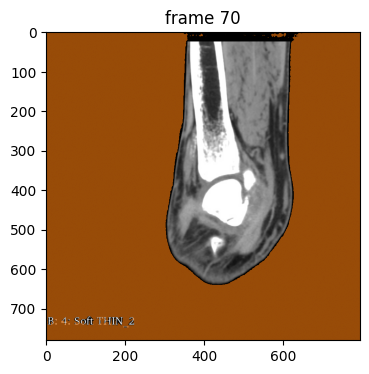

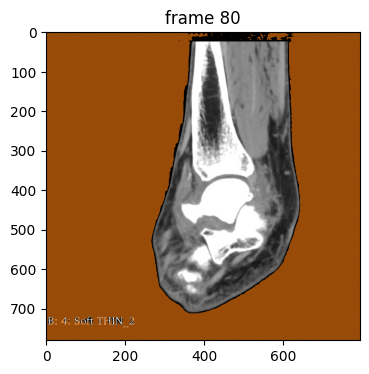

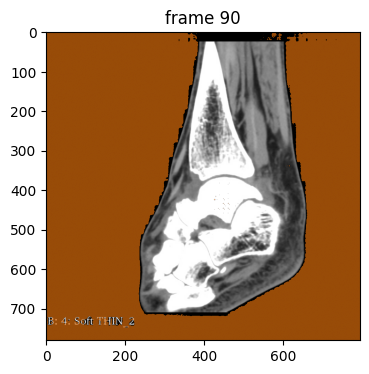

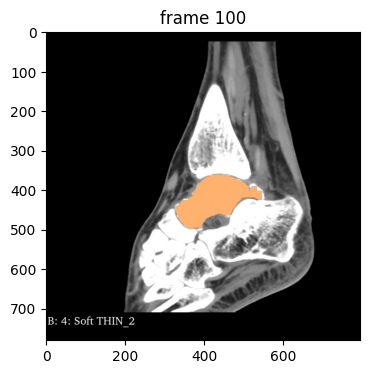

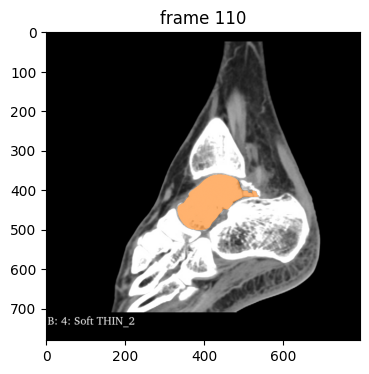

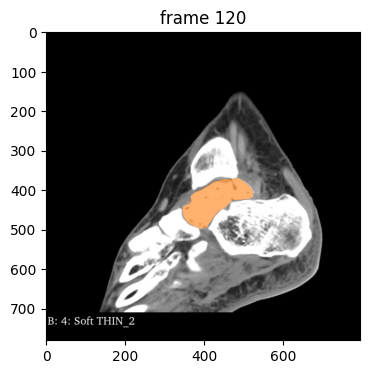

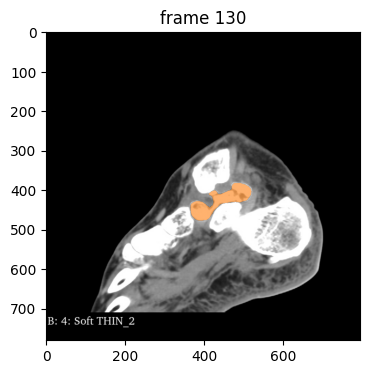

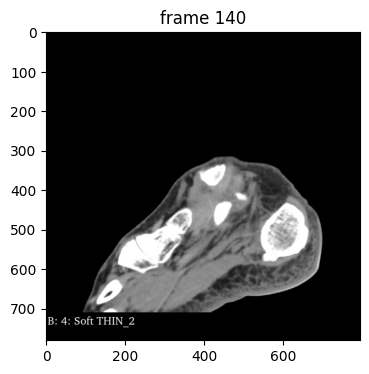

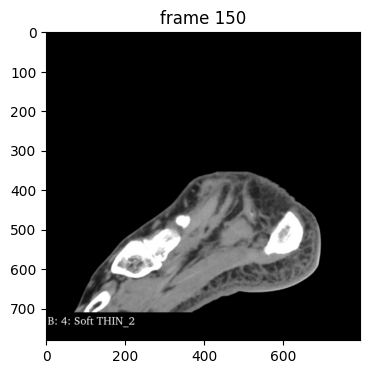

In [39]:
# run propagation throughout the video and collect the results in a dict
video_segments = {}  # video_segments contains the per-frame segmentation results
for out_frame_idx, out_obj_ids, out_mask_logits in predictor.propagate_in_video(inference_state, 
    start_frame_idx=61, max_frame_num_to_track=69):
    video_segments[out_frame_idx] = {
        out_obj_id: (out_mask_logits[i] > 0.0).cpu().numpy()
        for i, out_obj_id in enumerate(out_obj_ids)
    }

# render the segmentation results every few frames
vis_frame_stride = 10
plt.close("all")
for out_frame_idx in range(0, len(frame_names), vis_frame_stride):
    if out_frame_idx in video_segments:  # Check if the frame was processed
        plt.figure(figsize=(6, 4))
        plt.title(f"frame {out_frame_idx}")
        plt.imshow(Image.open(os.path.join(video_dir, frame_names[out_frame_idx])))
        for out_obj_id, out_mask in video_segments[out_frame_idx].items():
            show_mask(out_mask, plt.gca(), obj_id=out_obj_id)

### Step 4: Add new prompts to further refine the masklet

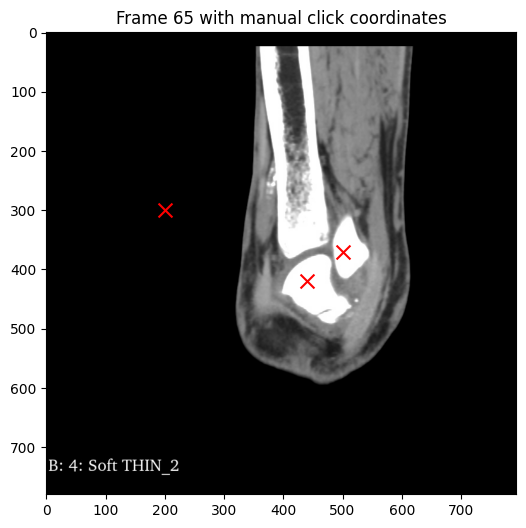

Manually selected coordinates: [(440, 420), (200, 300), (500, 370)]


In [90]:
# import matplotlib.pyplot as plt
from PIL import Image
import os

# Manually input coordinates after visually inspecting the image
manual_coords = [(440, 420),(200,300), (500, 370)]  # Example coordinates

# Display the CT image
frame_idx = 65  # Replace with the index of the CT image you want to work with
image_path = os.path.join(video_dir, frame_names[frame_idx])
img = Image.open(image_path)

plt.figure(figsize=(9, 6))
plt.imshow(img)
plt.title(f"Frame {frame_idx} with manual click coordinates")

# Unpack the manual coordinates and plot them
x_coords, y_coords = zip(*manual_coords)
plt.scatter(x_coords, y_coords, color='red', marker='x', s=100)  # Plot all points
plt.show()

# Use the coordinates in your segmentation task
print(f"Manually selected coordinates: {manual_coords}")

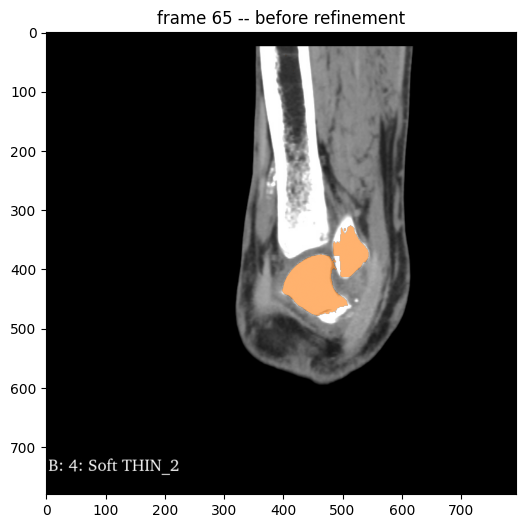

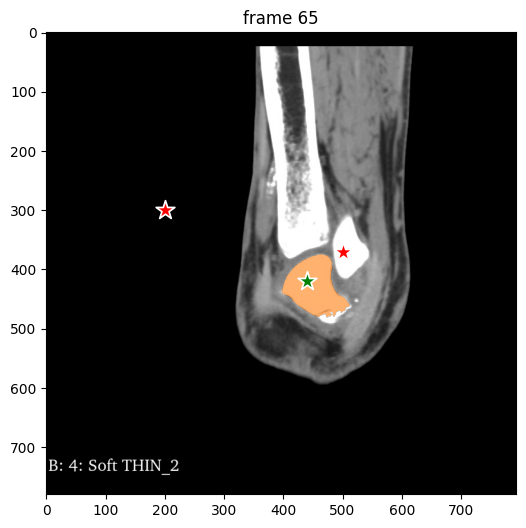

In [92]:
ann_frame_idx = 65  # the frame index we interact with
ann_obj_id = 1  # give a unique id to each object we interact with (it can be any integers)

# show the segment before further refinement
plt.figure(figsize=(9, 6))
plt.title(f"frame {ann_frame_idx} -- before refinement")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[ann_frame_idx])))
show_mask(video_segments[ann_frame_idx][ann_obj_id], plt.gca(), obj_id=ann_obj_id)

# Let's add a positive click at (x, y) = (210, 350) to get started
points = np.array(manual_coords, dtype=np.float32)
# for labels, `1` means positive click and `0` means negative click
labels = np.array([1,0,0], np.int32)
_, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
    inference_state=inference_state,
    frame_idx=ann_frame_idx,
    obj_id=ann_obj_id,
    points=points,
    labels=labels,
)

# show the results on the current (interacted) frame
plt.figure(figsize=(9, 6))
plt.title(f"frame {ann_frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[ann_frame_idx])))
show_points(points, labels, plt.gca())
show_mask((out_mask_logits > 0.0).cpu().numpy(), plt.gca(), obj_id=ann_obj_id)

### Step 5: Propagate the prompts (again) to get the masklet across the video

propagate in video: 100%|██████████| 70/70 [00:39<00:00,  1.79it/s]


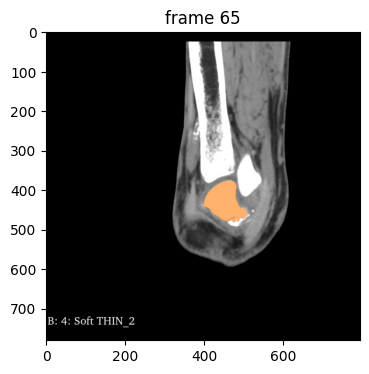

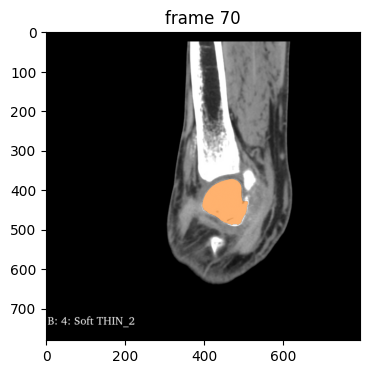

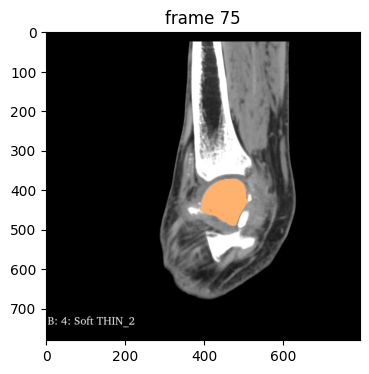

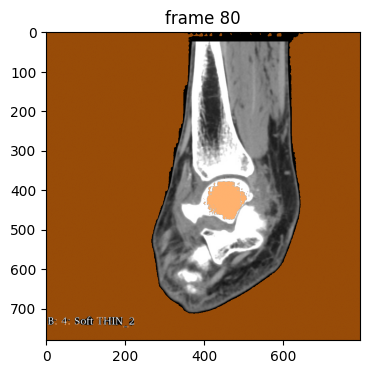

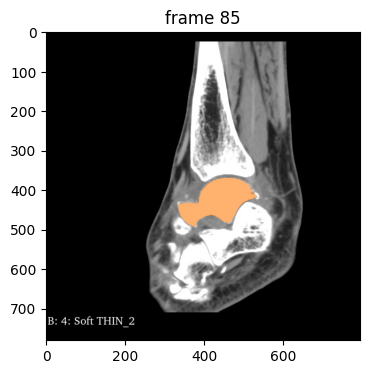

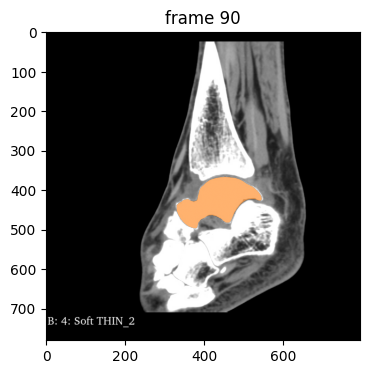

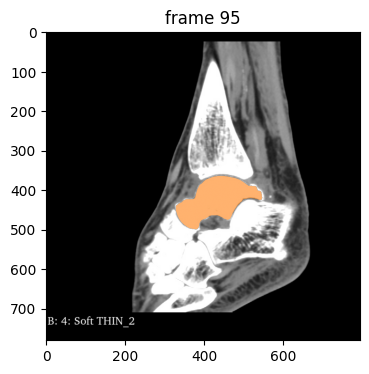

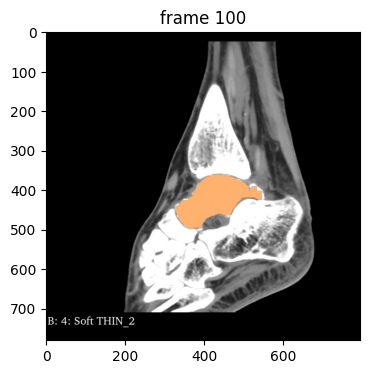

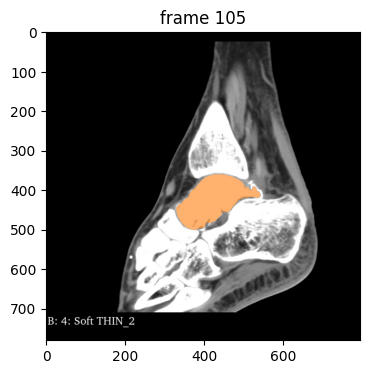

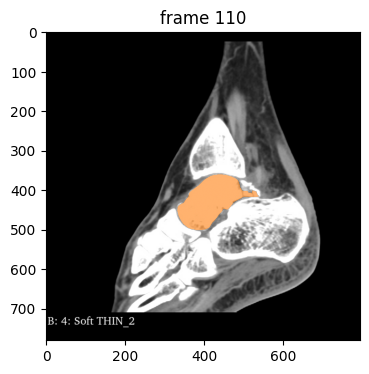

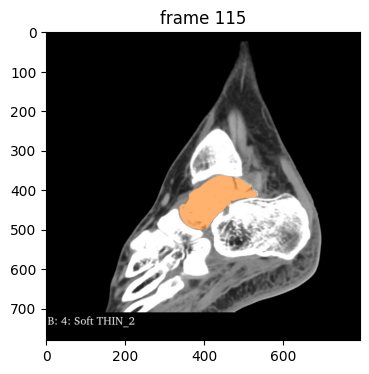

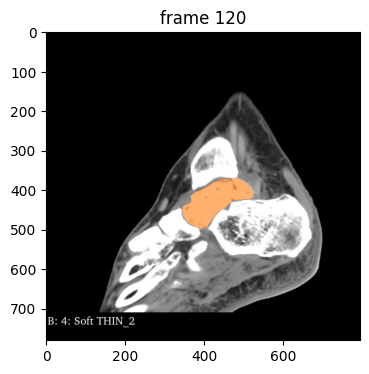

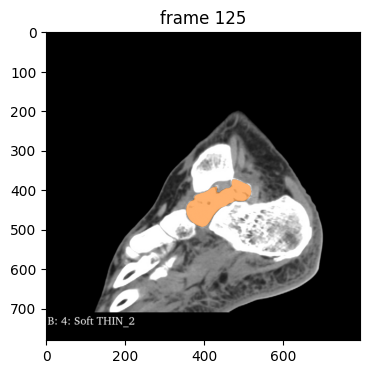

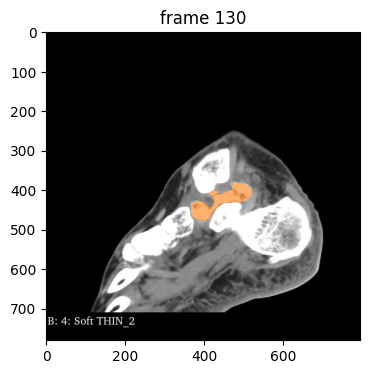

In [93]:
# run propagation throughout the video and collect the results in a dict
video_segments = {}  # video_segments contains the per-frame segmentation results
for out_frame_idx, out_obj_ids, out_mask_logits in predictor.propagate_in_video(inference_state, 
    start_frame_idx=61, max_frame_num_to_track=69):
    video_segments[out_frame_idx] = {
        out_obj_id: (out_mask_logits[i] > 0.0).cpu().numpy()
        for i, out_obj_id in enumerate(out_obj_ids)
    }

# render the segmentation results every few frames
vis_frame_stride = 5
plt.close("all")
for out_frame_idx in range(0, len(frame_names), vis_frame_stride):
    if out_frame_idx in video_segments:  # Check if the frame was processed
        plt.figure(figsize=(6, 4))
        plt.title(f"frame {out_frame_idx}")
        plt.imshow(Image.open(os.path.join(video_dir, frame_names[out_frame_idx])))
        for out_obj_id, out_mask in video_segments[out_frame_idx].items():
            show_mask(out_mask, plt.gca(), obj_id=out_obj_id)

### Repeating step 4 and step 5

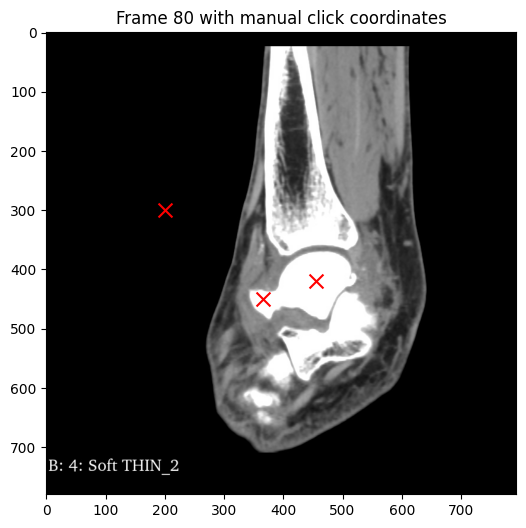

Manually selected coordinates: [(455, 420), (200, 300), (365, 450)]


In [100]:
# import matplotlib.pyplot as plt
from PIL import Image
import os

# Manually input coordinates after visually inspecting the image
manual_coords = [(455, 420),(200, 300), (365, 450)]  # Example coordinates

# Display the CT image
frame_idx = 80  # Replace with the index of the CT image you want to work with
image_path = os.path.join(video_dir, frame_names[frame_idx])
img = Image.open(image_path)

plt.figure(figsize=(9, 6))
plt.imshow(img)
plt.title(f"Frame {frame_idx} with manual click coordinates")

# Unpack the manual coordinates and plot them
x_coords, y_coords = zip(*manual_coords)
plt.scatter(x_coords, y_coords, color='red', marker='x', s=100)  # Plot all points
plt.show()

# Use the coordinates in your segmentation task
print(f"Manually selected coordinates: {manual_coords}")

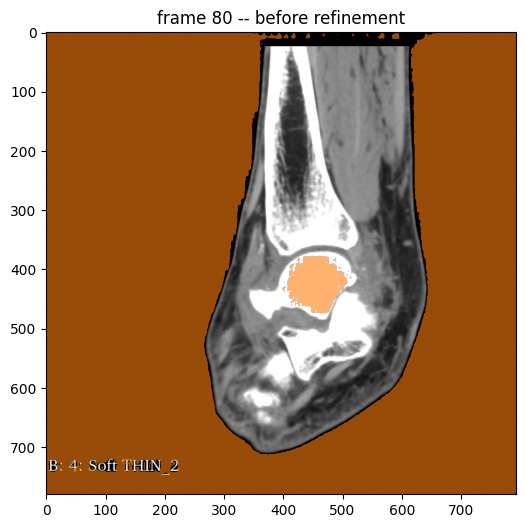

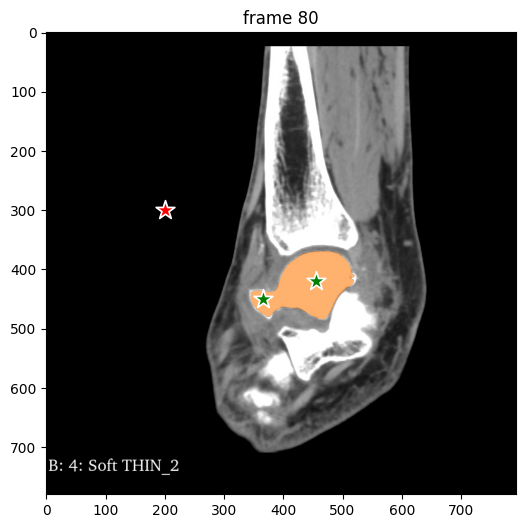

In [101]:
ann_frame_idx = 80  # the frame index we interact with
ann_obj_id = 1  # give a unique id to each object we interact with (it can be any integers)

# show the segment before further refinement
plt.figure(figsize=(9, 6))
plt.title(f"frame {ann_frame_idx} -- before refinement")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[ann_frame_idx])))
show_mask(video_segments[ann_frame_idx][ann_obj_id], plt.gca(), obj_id=ann_obj_id)

# Let's add a positive click at (x, y) = (210, 350) to get started
points = np.array(manual_coords, dtype=np.float32)
# for labels, `1` means positive click and `0` means negative click
labels = np.array([1,0,1], np.int32)
_, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
    inference_state=inference_state,
    frame_idx=ann_frame_idx,
    obj_id=ann_obj_id,
    points=points,
    labels=labels,
)

# show the results on the current (interacted) frame
plt.figure(figsize=(9, 6))
plt.title(f"frame {ann_frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[ann_frame_idx])))
show_points(points, labels, plt.gca())
show_mask((out_mask_logits > 0.0).cpu().numpy(), plt.gca(), obj_id=ann_obj_id)

propagate in video: 100%|██████████| 70/70 [00:38<00:00,  1.81it/s]


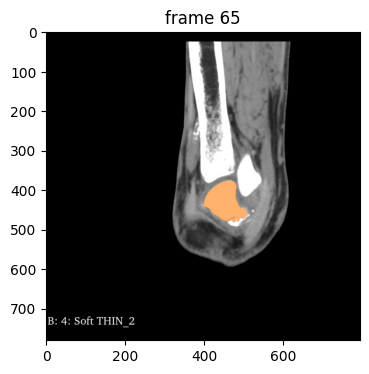

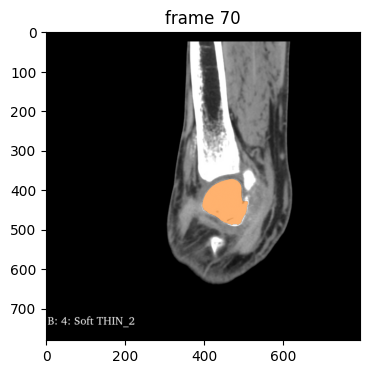

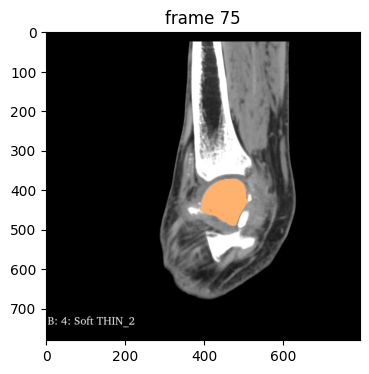

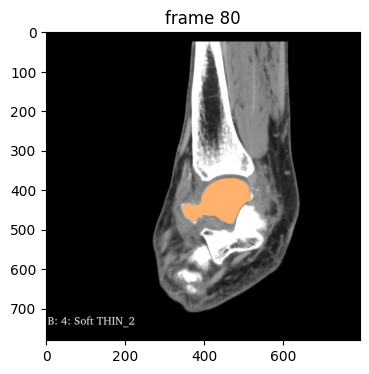

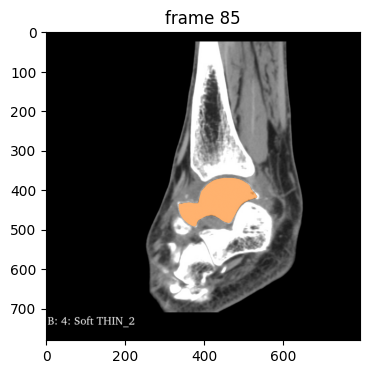

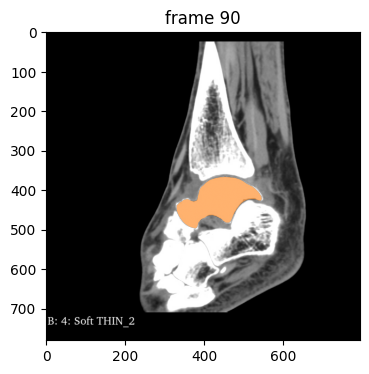

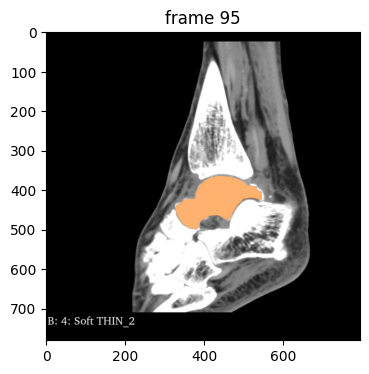

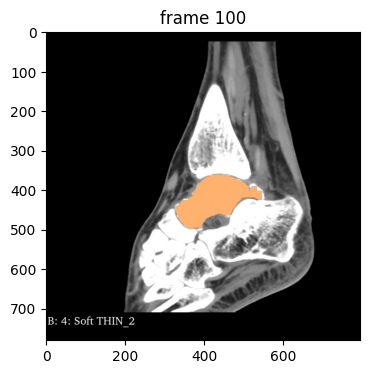

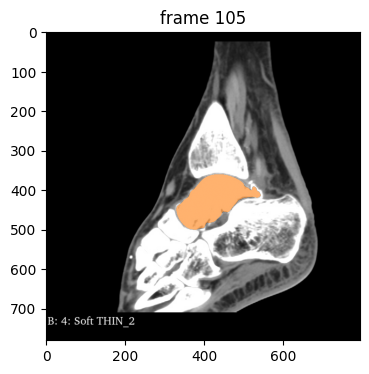

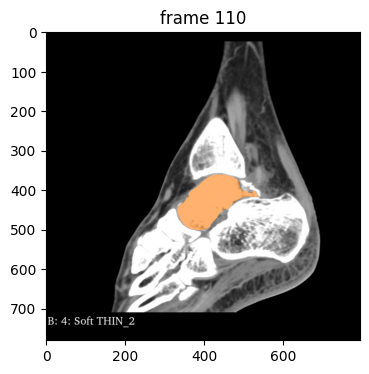

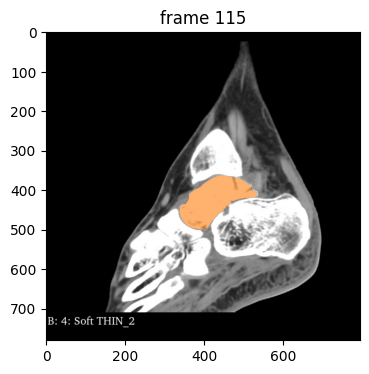

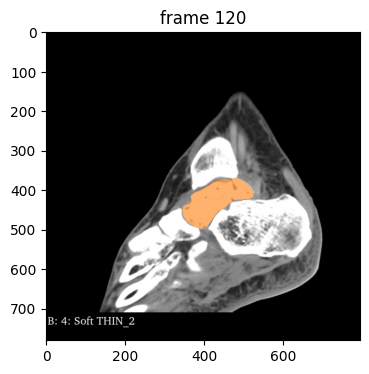

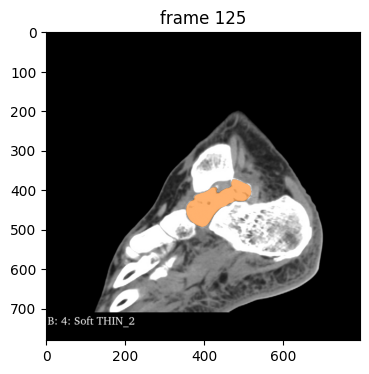

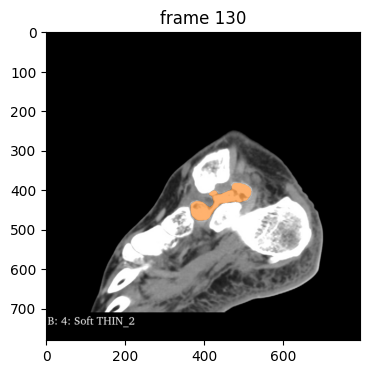

In [102]:
# run propagation throughout the video and collect the results in a dict
video_segments = {}  # video_segments contains the per-frame segmentation results
for out_frame_idx, out_obj_ids, out_mask_logits in predictor.propagate_in_video(inference_state, 
    start_frame_idx=61, max_frame_num_to_track=69):
    video_segments[out_frame_idx] = {
        out_obj_id: (out_mask_logits[i] > 0.0).cpu().numpy()
        for i, out_obj_id in enumerate(out_obj_ids)
    }

# render the segmentation results every few frames
vis_frame_stride = 5
plt.close("all")
for out_frame_idx in range(0, len(frame_names), vis_frame_stride):
    if out_frame_idx in video_segments:  # Check if the frame was processed
        plt.figure(figsize=(6, 4))
        plt.title(f"frame {out_frame_idx}")
        plt.imshow(Image.open(os.path.join(video_dir, frame_names[out_frame_idx])))
        for out_obj_id, out_mask in video_segments[out_frame_idx].items():
            show_mask(out_mask, plt.gca(), obj_id=out_obj_id)